In [1]:
#FUNCIONES DE ACTIVACIÓN PARA REDES NEURONALES MULTICAPA
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit,softmax

class function(object):
    def __init__(self,funcion,derivative=None,rand_init=(0,1)):
        self.F=funcion
        self.D=derivative
        self.Rand_init=rand_init

lineal=function(funcion=lambda x:x,
                derivative=lambda x:1,
                rand_init=(-1,1))

sigm=function(funcion=lambda x: expit(x),
              derivative=lambda x: expit(x)*(1-expit(x)),
              rand_init=(0,1))

tanh=function(funcion=lambda x:(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)),
              derivative=lambda x:1-((np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)))**2,
              rand_init=(-1,1))

tanh1=function(funcion=lambda x:np.tanh(x),
               derivative=lambda x:1-np.tanh(x)**2,
               rand_init=(-1,1))

relu=function(funcion=lambda x: np.maximum(0, x),
              derivative=lambda x: np.where(x<=0,0,1),
              rand_init=(0,1))

softmaxf=function(funcion=lambda x: softmax(x),
                  derivative=lambda x:softmax(x)*(1-softmax(x)),
                  rand_init=(0,1))


# funciones de coste
mse=function(funcion=lambda Yp, Yr: np.mean((Yp - Yr) ** 2) ,
                 derivative=lambda Yp, Yr: (Yp - Yr))

cross_entropy=function(funcion=lambda yscore,yreal:-np.sum(yreal*np.log(yscore))/yscore.shape[0],
                       derivative=lambda yscore,yreal:yscore-yreal)

Funciones={"relu":relu,
           "sigm":sigm,
           "relu":relu,
           "tanh":tanh,
           "tanh1":tanh1,
           "lineal":lineal,
           "softmax":softmaxf}

Loss={"mse":mse,
      "cross_entropy":cross_entropy}

_x = np.linspace(-10, 10, 100)



In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
Min_Max = preprocessing.MinMaxScaler()
Ordinal =preprocessing.OrdinalEncoder()


def one_hot_cols(df,cols_to_one):
    one_hot=pd.get_dummies(df,cols_to_one,columns=cols_to_one)
    return one_hot

def fit_cols(df, cols_to_fit,fit_function ):
    for col in cols_to_fit:
        df[col] = pd.DataFrame(fit_function.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

def split_Dataset(mypandas, cols_for_Y,size=0.2,state=1):
    
    X =  mypandas.drop(cols_for_Y, axis=1)
    Y = mypandas[cols_for_Y]
    X.head()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=size, random_state=state)
    return X_train.to_numpy(), X_test.to_numpy(), Y_train.to_numpy(), Y_test.to_numpy()

In [6]:
#Hacer aquí la normalizacion de los datos
import csv
data = pd.read_csv('datasets/transfusion.csv', encoding='utf-8' )
data
data=one_hot_cols(data,['whether he/she donated blood in March 2007'])
dataset= fit_cols(data,data.columns,Min_Max)
Xtrain,X_test , Ytrain, Y_test = split_Dataset(data,['whether he/she donated blood in March 2007_0','whether he/she donated blood in March 2007_1'])
print(Xtrain.shape)
print(Ytrain.shape)
print(X_test.shape)
print(Y_test.shape)
display(Xtrain)

(598, 4)
(598, 2)
(150, 4)
(150, 2)


array([[0.31081081, 0.04081633, 0.04081633, 0.47916667],
       [0.18918919, 0.06122449, 0.06122449, 0.25      ],
       [0.14864865, 0.        , 0.        , 0.09375   ],
       ...,
       [0.05405405, 0.32653061, 0.32653061, 0.71875   ],
       [0.10810811, 0.18367347, 0.18367347, 0.63541667],
       [0.05405405, 0.10204082, 0.10204082, 0.14583333]])

In [7]:
# CLASE DE LA CAPA DE LA RED
from IPython.display import clear_output
import time

class neural_layer(object):
    def __init__(self, n_conn, n_neur, activation="relu"):
        self.act = Funciones[activation]
        self.activation=activation
        self.random=self.act.Rand_init  
        self.shape=(n_conn,n_neur)
        self.Initialize()
        
    def show(self,Full=False):
        print(f"Pesos shape:{np.shape(self.W)} bias shape:{np.shape(self.b)} Activation:{self.activation}")
        print(f"Activation:{self.activation}, Random:{self.random}")
        print("______________________")
        if Full:
            print(f"Pesos:")
            print(self.W)
            print("#####")
            print(f"Bias:")
            print(self.b)
            
    def Initialize(self):
        #inicializa los pesos iniciales con aleatorios
        self.b = np.random.uniform(*self.random,(1, self.shape[1]))      
        self.W = np.random.uniform(*self.random,self.shape)
        
        
        
#CLASE RED NEURONAL MULTICAPA        
class Neural_Net(object):
    def __init__(self,Input,loss):
        self.loss = Loss[loss]
        self.Funcion_Loss=loss
        self.Input=Input
        self.NN=None;
              
    def Add_Layer(self,Num_neurons, function):
        if self.NN is None:
            self.NN=[]
            self.NN.append(neural_layer(self.Input,Num_neurons,function))
        else:
            _,L_input=np.shape(self.NN[-1].W)
            self.NN.append(neural_layer(L_input,Num_neurons,function))
            
    def Show_Model(self, Full=False):
        print(f"Input shape:{self.Input}, Loss: {self.Funcion_Loss}")
        for i,L in enumerate(self.NN):
            print(F"Layer_{i}:")
            L.show(Full)
            
            
    # fucnción de predicción (fordware pass)    
    def Predict(self,X):  
      #sólo podemos pasar Numpy  
      sx=np.shape(X)
      X=X.reshape(1,sx[0])
      if self.NN is None:
          print("error in Predict Method ( not NEURAL network available)")
          return 0
        
      out = [(None, X)] #primer data necesario
      # Forward pass
      for l, layer in enumerate(self.NN):
          z = out[-1][1] @ self.NN[l].W + self.NN[l].b
          a = self.NN[l].act.F(z)
          out.append((z, a))
      return out[-1][1]
    
    
    # función retropropagación del error
    def _backward_pass(self, X, Y,lr=0.01):
      sx=np.shape(X)
      sy=np.shape(Y)   
      X=X.reshape(1,sx[0])
      Y=Y.reshape(1,sy[0])

      # Forward pass
      out = [(None, X)] #primer data necesario
      for l, layer in enumerate(self.NN):
            z = out[-1][1] @ self.NN[l].W + self.NN[l].b
            a = self.NN[l].act.F(z)
            out.append((z, a))

      # Backward pass 
      deltas = []
      for l in reversed(range(0, len(self.NN))):
        z = out[l+1][0]
        a = out[l+1][1]
        if l == len(self.NN) - 1:
            deltas.insert(0, self.loss.D(a, Y) * self.NN[l].act.D(a)) # La última capa
        else:
            deltas.insert(0, deltas[0] @ _W.T * self.NN[l-1].act.D(a))
        _W = self.NN[l].W #los pesos en la capa superior
 
        # Gradient descent. actualizamos pesos 
        self.NN[l].b = self.NN[l].b - (deltas[0]* lr)
        self.NN[l].W = self.NN[l].W - (lr * (out[l][1].T @ deltas[0]))
      return out[-1][1]

    # función de entrenamiento de la red
    def Train(self,X,Y,lr=0.01,epoch=10,batch_size=1):
        H_loss = []
        H_acc=[]
        
        # inicializamos las capas neuronales a valores ramdom del rango de la función
        for Layer in self.NN:
            Layer.Initialize()
            
        for i in range(epoch):
            account=0
            epoch_Loss=0
            epoch_Acc=0
            # Entrenemos a la red! con el dataset de validación
            for j in range(len(X)):
                pY = self._backward_pass(X[j,:], Y[j,:],lr)#fila, fila, learning rate
                epoch_Loss+=self.loss.F(pY[0],Y[j,:])
                if (Y[j,:]==np.round(pY)).all():#condicion de acertar
                    epoch_Acc+=1
            H_acc.append(epoch_Acc/len(Y)*100)    
            H_loss.append(epoch_Loss/len(Y))#media del error
            
            #imprimimos por pantalla resultados
            print("Epoch={}, Accurary={} Loss={}".format(i,round(H_acc[-1],3),round(H_loss[-1],7)))
            clear_output(wait=True)
        print("Epoch={}, Accuracy={} Loss={}".format(i,round(H_acc[-1],3),round(H_loss[-1],7)))
        return H_loss,H_acc

    
# VISUALIZACIÓN Y TEST
def Show_Loss_Acc(H_loss,H_acc):
    plt.plot(range(len(H_loss)), H_loss,"tab:blue")
    plt.ylabel("loss function ")
    plt.xlabel("EPOCH NUMBER")
    plt.show()
    plt.plot(range(len(H_acc)), H_acc, "tab:red")
    plt.ylabel("ACCURACY")
    plt.xlabel("EPOCH NUMBER")
    plt.show()
       
def print_predict(neural_net,X,Y):
    for i in range(len(X)):
        sal_float=neural_net.Predict(X[i])
        sal=np.round(sal_float)
        
        if (Y[i]==np.round(sal)).all():
            print("Input:{}-- Real:{} predict: {} predict_float:{}".format(X[i],Y[i],sal,np.round(sal_float,2)))
        else:
            print("\x1b[31m Input:{}-- Real:{} predict: {} predict_float:{}\x1b[0m".format(X[i],Y[i],sal,np.round(sal_float,2)))


        

In [30]:
#DEFINIMOS LOS MODELOs
def Model1():
    red=Neural_Net(Input=4,loss="cross_entropy")
    red.Add_Layer(10,"relu")
    red.Add_Layer(2,"softmax")
    return red

def Model2():
    red=Neural_Net(Input=4,loss="mse")
    red.Add_Layer(20,"tanh")
    red.Add_Layer(2,"tanh1")
    return red

def Model3(): 
    red=Neural_Net(Input=4,loss="cross_entropy")
    red.Add_Layer(10,"sigm")
    red.Add_Layer(20,"tanh")
    red.Add_Layer(8,"relu")
    red.Add_Layer(2,"softmax")
    return red

In [31]:
cnn=Model2()
cnn.Show_Model()
cnn.Show_Model(True)

Input shape:4, Loss: mse
Layer_0:
Pesos shape:(4, 20) bias shape:(1, 20) Activation:tanh
Activation:tanh, Random:(-1, 1)
______________________
Layer_1:
Pesos shape:(20, 2) bias shape:(1, 2) Activation:tanh1
Activation:tanh1, Random:(-1, 1)
______________________
Input shape:4, Loss: mse
Layer_0:
Pesos shape:(4, 20) bias shape:(1, 20) Activation:tanh
Activation:tanh, Random:(-1, 1)
______________________
Pesos:
[[ 0.7098945   0.26425909 -0.77177262  0.66209214 -0.63497857  0.88724397
   0.36250129  0.18979821 -0.91327426  0.57917986 -0.32544966  0.60684963
  -0.79018319 -0.31395705 -0.28449814 -0.17852467 -0.41558052  0.8644313
  -0.23458586 -0.24053034]
 [ 0.5014043  -0.34540305 -0.26256035  0.20600359  0.44566246  0.0263517
   0.03675193 -0.71257035 -0.95830283  0.20674574 -0.78242423 -0.71651425
   0.52357943 -0.91058863  0.26842817  0.86880898  0.81571967 -0.28837625
  -0.61236291 -0.42714256]
 [-0.86776103 -0.99449264  0.9021872   0.56392486 -0.38122412  0.84833422
   0.48912166 -

Epoch=359, Accuracy=78.595 Loss=0.1520781


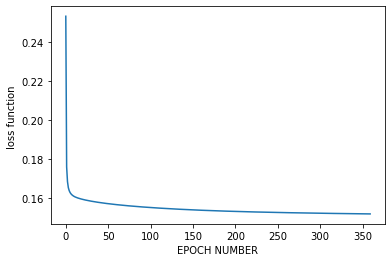

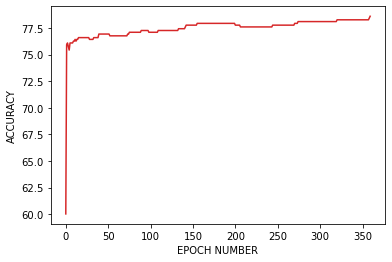

In [35]:
print(Xtrain.shape)
print(Ytrain.shape)


loss,accuracy=cnn.Train(Xtrain,Ytrain,0.01,360)
Show_Loss_Acc(loss,accuracy)

In [ ]:
print_predict(cnn,Xtrain,Ytrain)
print("::::::::::::::::::::::::::::")


np.round(cnn.Predict(np.array([0.51,0.35,0.14,0.02])))